In [57]:
class RotatedSmoothed(Dataset):
    def __init__(
        self,
        exemplars_per_digit,
        digits=np.arange(10),
        percent_transformations=1.0,
        noise=0.1,
        seed=0,
        n_repeats=50,
        ordered=False,
        ravel=True,
    ):

        super().__init__()

        self.name = "rotated-mnist"
        self.dim = 
        self.digits = digits
        self.percent_transformations = percent_transformations
        self.noise = noise
        self.seed = seed
        self.ordered = ordered
        self.ravel = ravel

        np.random.seed(seed)

        random_classes = np.random.uniform(-1, 1, size=(n_classes,) + (img_size,img_size))

        all_labels = mnist[:, 0]
        label_idxs = {a: np.where(all_labels == a)[0] for a in digits}

        mnist = mnist[:, 1:]
        mnist = mnist / 255
        # TODO: VERIFY NORMALIZATION WITH ROTATION BORDERS
        #         mnist = mnist - mnist.mean(axis=1, keepdims=True)
        #         mnist = mnist / mnist.std(axis=1, keepdims=True)
        mnist = mnist.reshape((len(mnist), 28, 28))

        n_rotations = int(359 * percent_transformations)
        all_rotations = np.arange(360)

        data = []
        labels = []
        exemplar_labels = []

        ex_idx = 0

        for number in digits:
            # Select digits
            idxs = np.random.choice(
                label_idxs[number], exemplars_per_digit, replace=False
            )

            # Rotate exemplars + Add noise
            for idx in idxs:
                img = mnist[idx]
                l = all_labels[idx]

                # Select rotations
                if not ordered:
                    np.random.shuffle(all_rotations)
                select_rotations = all_rotations[:n_rotations]

                for angle in select_rotations:
                    for r in range(n_repeats):
                        t = transform.rotate(img, angle)
                        t -= t.mean(keepdims=True)
                        t /= t.std(keepdims=True)
                        n = np.random.uniform(-noise, noise, size=img.shape)
                        t = t + n
                        if ravel:
                            data.append(t.ravel())
                        else:
                            data.append(t)
                        labels.append(l)
                        exemplar_labels.append(ex_idx)

                ex_idx += 1

        data = np.array(data)
        if not ravel:
            self.channels = 1
            data = data.reshape((data.shape[0], 1, 28, 28))
        self.data = torch.Tensor(data)
        self.labels = labels
        self.exemplar_labels = exemplar_labels
        self.exemplars_per_digit = exemplars_per_digit
        self.n_repeats = n_repeats

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

    def __len__(self):
        return len(self.data)

SyntaxError: invalid syntax (<ipython-input-57-ac5c1e26a8a9>, line 17)

In [31]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
from scipy import ndimage
from skimage import transform

def compute_disk_pixels(img_size):
    if img_size[0] % 2 == 0 or img_size[1] % 2 == 0:
        raise ValueError(
            "Image size should be a tuple of odd numbers to ensure centered rotational symmetry."
        )
    v, h = np.mgrid[: img_size[0], : img_size[1]]
    equation = (v - ((img_size[0] - 1) / 2)) ** 2 + (
        h - ((img_size[1] - 1) / 2)
    ) ** 2
    circle = equation < (equation.max() / 2)
    return circle


def translate(img, x=0, y=0):
    """
    Given an image and offset x, y, returns a translated image up in y and right in x
    """
    new_img = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            oldi = (i + y) % img.shape[0]
            oldj = (j - x) % img.shape[1]
            new_img[i, j] = img[oldi, oldj]
    return new_img


def gen_random_data(img_size, n_classes, group_type, n_transformations):

    X = np.random.uniform(-1, 1, size=(n_classes, img_size, img_size))
    X = np.array([ndimage.gaussian_filter(xi, sigma=1) for xi in X])
    
    if group_type == 'rotation':
        in_circle = compute_disk_pixels((img_size,img_size))
        X[:,~in_circle] = 0
        
        thetas = np.linspace(0, 365, n_transformations)
        # Remember that the outer loop is the 'inner loop'
        X = np.array([transform.rotate(xi, th) for xi in X for th in thetas])
        
    elif group_type == 'translation':
        percent_transformations = 0.1
        all_transformations = list(
            itertools.product(
                np.arange(img_size),
                np.arange(img_size),
            )
        )
        n_transformations = int(len(all_transformations) * percent_transformations)
        select_transformations = all_transformations[:n_transformations]
        X = np.array([translate(xi, x=xx, y=yy) for xi in X for (xx,yy) in select_transformations])
        
    elif group_type == 'scaling':
        print(group_type)

    X -= np.mean(X, axis=(1, 2), keepdims=True)
    X /= np.std(X, axis=(1, 2), keepdims=True)
    n_transformations_from_X = X.shape[0] // n_classes
    Y = np.concatenate([np.array([i]*n_transformations_from_X) for i in range(n_classes)])
    return X,Y




X,Y = gen_random_data(65,5,'translation',100)

In [34]:
X.shape[0]//5

211

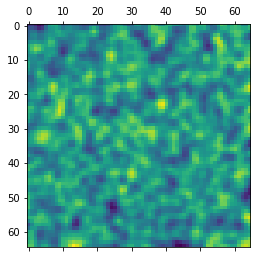

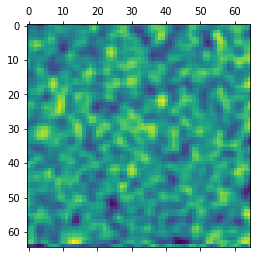

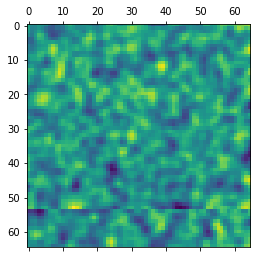

In [29]:
plt.matshow(X[0])
plt.matshow(X[1])
plt.matshow(X[11])
plt.show()

In [ ]:
import svis

svis.animated_video(X, interval=50, figsize=(10,10))